# Kickstarter EDA

## Preparation

In [29]:
import pandas as pd
import numpy as np
import glob

import json
import csv

### Load Data

In [30]:
df_raw = pd.concat(pd.read_csv(f) for f in glob.glob("../data_raw/*.csv"))

In [31]:
df = df_raw.copy()

### Features

In [32]:
df.columns

Index(['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'created_at', 'creator', 'currency', 'currency_symbol',
       'currency_trailing_code', 'current_currency', 'deadline',
       'disable_communication', 'friends', 'fx_rate', 'goal', 'id',
       'is_backing', 'is_starrable', 'is_starred', 'launched_at', 'location',
       'name', 'permissions', 'photo', 'pledged', 'profile', 'slug',
       'source_url', 'spotlight', 'staff_pick', 'state', 'state_changed_at',
       'static_usd_rate', 'urls', 'usd_pledged', 'usd_type'],
      dtype='object')

### Shape

In [33]:
df.shape

(209222, 37)

## Data Cleaning

We drop the following columns.
- `blurb`, `slug` and `photo`, because they might only be exploitable through a semantic or context analysis,
- `currency_symbol`, `currency_trailing_code`, because they are redundant,
- `friends`, `is_starrable` and `permission`, because they do not contain any information,
- `disable_communication`, `is_backing` and `is_starred`, because they have an entry only for the same 300 data points and it is questionable whether the missing entries may be treated as one category; later on we might try this with one of them and drop the other two,  
- `urls`, `source_url` and `profile` because they do not contain additional information.
- `backers_count`, `state_changed_at`, `spotlight` and `staff_pick`, because the creator does not know them in adcvance.

In [34]:
df = df.drop(["backers_count", "blurb", "slug", "photo", "currency_symbol", "currency_trailing_code", "state_changed_at",
              "friends", "permissions", "disable_communication", "is_backing", "is_starred","urls", 
              "source_url", "profile", "usd_type", "spotlight", "staff_pick", "is_starrable"], axis = 1)

### Goal cutoff and log

The distribution of `goal` is sporadic:

In [35]:
df.goal.max(), df.goal.min(), df.goal.mean(), df.goal.median(), df.goal.std()

(100000000.0, 0.01, 49176.035413293044, 5000.0, 1179427.3069999542)

Let us see how many data points get lost for certain `goal` cutoffs:

In [36]:
print('cutoff = 10,000,000:', df.query('goal > 10000000').goal.count())
print('cutoff = 5,000,000:', df.query('goal > 5000000').goal.count())
print('cutoff = 2,000,000:', df.query('goal > 2000000').goal.count())
print('cutoff = 1,000,000:', df.query('goal > 1000000').goal.count())

cutoff = 10,000,000: 90
cutoff = 5,000,000: 190
cutoff = 2,000,000: 416
cutoff = 1,000,000: 720


We cut off at 10,000,000 and take the log.

In [37]:
df = df.query('goal < 10000001')
df.goal = df.eval('log(goal)')

Histogram:

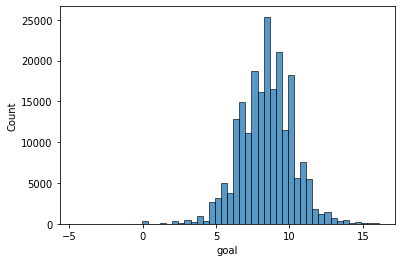

In [38]:
import seaborn as sns
sns.histplot(df.goal,bins=50);

### Category

We extract the internal Kickstarter category identifiers and drop `category` afterwards. For possible later use, we keep a list of the category ids.

In [39]:
df.category.isnull().sum()

0

In [40]:
df['category'] = [json.loads(x) for x in df.category]
df["cat_id"] = [x["id"] for x in df.category]

categories = sorted(set([(x['id'], x['slug']) for x in df.category]))
with open ('../script/kickstarter_util/categories.csv', 'w') as csvfile:
    filewriter = csv.writer(csvfile)
    for row in categories:
        filewriter.writerow(row)

df.drop('category', axis=1, inplace=True)

### Pledges and currencies 

There are no obvious relations between the corresponding features. In particular, the values in `usd_pledged` do not match with the conversion of `pledged` using `fx_rate` or `static_usd_rate`. Therefore, we take the max value for these columns as the correct amount. All other currency info can be dropped.

In [41]:
# check if currency - USD conversion with fx_rate and static_usd_rate matches usd_pledged value
print("pledged * static_usd_rate == usd_pledged")
print(df.eval("pledged * static_usd_rate == usd_pledged").value_counts())
print("pledged * fx_rate == usd_pledged")
print(df.eval("pledged * fx_rate == usd_pledged").value_counts())
print("converted_pledged_amount == usd_pledged")
print(df.eval("converted_pledged_amount == usd_pledged").value_counts())
print("pledged * static_usd_rate == converted_pledged_amount")
print(df.eval("pledged * static_usd_rate == converted_pledged_amount").value_counts())
print("pledged * fx_rate == converted_pledged_amount")
print(df.eval("pledged * fx_rate == converted_pledged_amount").value_counts())
print(df.eval("converted_pledged_amount == pledged + usd_pledged").value_counts())

df["max_pledged"] = [max(df.pledged.iloc[x], 
df.usd_pledged.iloc[x], 
df.converted_pledged_amount.iloc[x]) for x in range(0,len(df))]
df = df.drop(["usd_pledged", "pledged", "converted_pledged_amount"], axis = 1)

df = df.drop(["static_usd_rate", "fx_rate", "currency", "current_currency"], axis = 1)

pledged * static_usd_rate == usd_pledged
True     193757
False     15375
dtype: int64
pledged * fx_rate == usd_pledged
True     153900
False     55232
dtype: int64
converted_pledged_amount == usd_pledged
True     140431
False     68701
dtype: int64
pledged * static_usd_rate == converted_pledged_amount
True     140431
False     68701
dtype: int64
pledged * fx_rate == converted_pledged_amount
True     140414
False     68718
dtype: int64
False    190798
True      18334
dtype: int64


### Status

Now we check whether `live` projects have met their goal and can be considered `succesful`. Afterwards, we drop `max_pledged` and all data points which are neither `successful` nor `failed`.


In [42]:
df.loc[df['max_pledged'] >= df.goal, 'state'] = "successful"

df.drop('max_pledged', axis=1, inplace=True)

df = df.query('state != "canceled" and state != "suspended" and state != "live"')

### Datetime columns

Turn entries of `created_at`, `launched`, and `deadline` into datetime:

In [43]:
df.created_at = pd.to_datetime(df.created_at, unit='s')
df.launched_at = pd.to_datetime(df.launched_at, unit='s')
df.deadline = pd.to_datetime(df.deadline, unit='s')

### Location

We drop nan rows and convert the json string into a dictonary to extract keys and values.

In [44]:
df.location.isnull().sum()
df.dropna(axis = 0, subset = ["location"], inplace = True)
df.location =[json.loads(x) for x in df.location]
df["location_type"] = [x["type"] for x in df.location]
df["location_city"] = [x["short_name"] for x in df.location]
df["location_state"] = [x["state"] for x in df.location]
df.drop('location', axis=1, inplace=True)

Instead of keeping `location_city` as is, which would lead to a lot of dummy variables, we define a location score based on the number of successful Kickstarter projects (minus the one under consideration).

In [45]:
dic = {x:0 for x in df.location_city}

dic.update({c:len(val)-1 for (c, s), val in df.groupby(['location_city', 'state']).groups.items() 
                if s == 'successful'})
df['location_score'] = [dic[c] for c in df.location_city]

df.drop(['location_city'], axis=1, inplace=True)


We write the corresponding dictionary into a csv file.

In [46]:
import codecs
with codecs.open ('../script/kickstarter_util/location_score.csv', 'w', encoding='utf-8') as csvfile:
    #csvfile.write(codecs.BOM_UTF8)
    filewriter = csv.writer(csvfile)
    for row in dic.items():
        filewriter.writerow(row)

### Name length and word count

Extract counts and drop `name`.

In [47]:
df[['name_length', 'name_words']] = [[len(x), len(x.split(' '))] for x in df.name]
df.drop('name', axis=1, inplace=True)

### Creator success rate

Count the successful/failed projects of each creator, minus one for the project under consideration 
and drop `creator_id` afterwards. `creator` will be needed below to extract gender.

In [48]:
df['creator_id'] = [x[x.find(':')+1 : x.find(',')] for x in df.creator]

dic_suc = {c:0 for c in df.creator_id.unique()}
dic_fai = dic_suc.copy()

dic_suc.update({c:len(val)-1 for (c, s), val in df.groupby(['creator_id', 'state']).groups.items() 
                if s == 'successful'})
dic_fai.update({c:len(val)-1 for (c, s), val in df.groupby(['creator_id', 'state']).groups.items() 
                if s == 'failed'})

df['projects_successful'] = [dic_suc[c] for c in df.creator_id]
df['projects_failed'] = [dic_fai[c] for c in df.creator_id]

df.drop('creator_id', axis=1, inplace=True)


We write the corresponding dictionaries into csv files.

In [49]:
with open ('../script/kickstarter_util/projects_successful.csv', 'w') as csvfile:
    filewriter = csv.writer(csvfile)
    for row in dic_suc.items():
        filewriter.writerow(row)

with open ('../script/kickstarter_util/projects_failed.csv', 'w') as csvfile:
    filewriter = csv.writer(csvfile)
    for row in dic_fai.items():
        filewriter.writerow(row)

### Duplicates
Remove `id` copies.

In [50]:
df.drop_duplicates(subset = "id", inplace=True)

### Gender

Extract gender from creator's name and drop `creator` afterwards.

In [52]:
df['creator_name'] = [x[x.find('":"')+3 : x.find('","')].split(' ')[0].lower() for x in df.creator]



In [62]:
dic = {c:2 for c in df.creator_name}
with codecs.open ('../script/kickstarter_util/names.csv', 'r', encoding='utf-8') as csvfile:
    filereader = csv.reader(csvfile)
    for row in filereader:
        if len(row) != 0:
            dic.update({row[0]:row[1]})

In [66]:

df['gender'] = [dic[c] for c in df.creator_name]

df.drop(['creator', 'creator_name'], axis=1, inplace=True)

### Final shape

In [67]:
df.shape

(177396, 16)

In [68]:
df.columns

Index(['country', 'created_at', 'deadline', 'goal', 'id', 'launched_at',
       'state', 'cat_id', 'location_type', 'location_state', 'location_score',
       'name_length', 'name_words', 'projects_successful', 'projects_failed',
       'gender'],
      dtype='object')

### Save cleaned data

In [70]:
df.to_csv('../data/kickstarter_cleaned.csv', index=False)